This notebook demonstrates how code from the mr-fitty package can be used to develop additional tools for working with XAFS data.

Note: when using MKL set OMP_NUM_THREADS=1.

In [1]:
import glob
import itertools
import logging
from operator import attrgetter
import os
import pprint
import sys
import time

import matplotlib.pyplot as plt
%matplotlib inline
import scipy.misc

import numpy as np
import pandas as pd
import scipy.cluster.hierarchy as hc
from scipy.spatial.distance import pdist

import sklearn.utils

from mrfitty.base import ReferenceSpectrum
from mrfitty.base import InterpolatedSpectrumSet

logging.basicConfig(level=logging.WARN)

In [2]:
sample_data_dir_path = os.path.join(sys.prefix, 'sample_data')
print('sample data is installed at "{}"'.format(sample_data_dir_path))
os.path.exists(sample_data_dir_path)

sample data is installed at "/home/jlynch/ttt/sample_data"


True

Read all sample reference and unknown spectra.

In [3]:
sample_data_reference_glob = os.path.join(sample_data_dir_path, 'reference/*als_cal*.e')
print('sample data reference glob: {}'.format(sample_data_reference_glob))
sample_data_unknown_glob = os.path.join(sample_data_dir_path, 'unknown/*.e')
print('sample data unknown glob: {}'.format(sample_data_unknown_glob))

sample data reference glob: /home/jlynch/ttt/sample_data/reference/*.e
sample data unknown glob: /home/jlynch/ttt/sample_data/unknown/*.e


In [4]:
sample_data_reference_list, _ = list(ReferenceSpectrum.read_all([sample_data_reference_glob]))
print('sample data reference file count: {}'.format(len(sample_data_reference_list)))
sample_data_unknown_list, _ = list(ReferenceSpectrum.read_all([sample_data_unknown_glob]))
print('sample data unknown file count: {}'.format(len(sample_data_unknown_list)))

sample data reference file count: 24
sample data unknown file count: 16


What are the maximum and minimum reference energies?

In [5]:
reference_min_energy = np.max([r.data_df.energy.values[0] for r in sample_data_reference_list])
reference_max_energy = np.min([r.data_df.energy.values[-1] for r in sample_data_reference_list])
print('reference minimum energy: {:5.2f}'.format(reference_min_energy))
print('reference maximum energy: {:5.2f}'.format(reference_max_energy))

reference minimum energy: 11830.00
reference maximum energy: 12097.14


What are the maximum and minimum unknown spectrum energies?

In [6]:
min_energy = np.max([r.data_df.energy.values[0] for r in sample_data_unknown_list])
max_energy = np.min([r.data_df.energy.values[-1] for r in sample_data_unknown_list])
print('minimum energy: {:5.2f}'.format(min_energy))
print('maximum energy: {:5.2f}'.format(max_energy))

minimum energy: 11777.73
maximum energy: 12171.83


In [7]:
interpolate_energy_range = np.linspace(start=reference_min_energy, stop=reference_max_energy, num=200)
print('interpolate_energy_range.shape: {}'.format(interpolate_energy_range.shape))
print('interpolate_energy_range:\n{}'.format(pprint.pformat(interpolate_energy_range.tolist()[:10])))

interpolate_energy_range.shape: (200,)
interpolate_energy_range:
[11830.0,
 11831.342407035176,
 11832.684814070351,
 11834.027221105527,
 11835.369628140703,
 11836.712035175879,
 11838.054442211056,
 11839.396849246232,
 11840.739256281408,
 11842.081663316583]


,Arsenopyrite_Julcani_OA.e,As2O3_ref_avg_als_cal.e,As_pyrite_A_Foster_sln.e,Fh2l_sorbed_arsenate_pH7_100uM_als_cal.e,Fh2l_sorbed_arsenate_pH7_10uM_als_cal.e,Fh2l_sorbed_arsenite_pH7_10um_als_cal.e,Fh2l_sorbed_arsenite_pH8_10um_als_cal.e,Lollingite_Lolling_avg_OA.e,OTT3_55_spot0.e,OTT3_55_spot1.e,...,arsenite_aqueous_als_cal.e,arsenopyrite_ref_als_cal.e,as2o5_powder_ref_als_cal.e,as2o5_ref_als_cal.e,goethite_sorbed_arsenate_ref_als_cal_avg.e,orpiment_all_ref_als_cal.e,scorodite_A_Foster_sln.e,sodium_arsenate_13BM_ref_als_cal.e,sodium_arsenate_ref_als_cal.e,sodium_arsenite_13BM_ref_als_cal.e
11830.000000,0.000488,0.001832,0.000320,0.003705,0.003152,0.006551,0.007235,0.000810,0.011528,-0.030387,...,0.000226,0.022018,0.002138,0.003166,-0.005283,0.000917,0.000598,0.004419,0.003011,0.003447
11831.342407,0.000867,0.001168,0.000516,0.002590,0.002583,0.006374,0.006279,0.001110,0.018064,-0.028140,...,-0.000210,0.015615,0.001245,0.002285,-0.004498,0.000208,0.000904,0.004694,0.002081,0.002474
11832.684814,0.001286,0.000542,0.000728,0.001603,0.001861,0.005457,0.005188,0.001442,0.017386,-0.019340,...,-0.000617,0.008387,0.000275,0.001503,-0.002359,-0.000432,0.001149,0.004427,0.001353,0.001537
11834.027221,0.001735,-0.000030,0.000972,0.000726,0.001038,0.004044,0.003925,0.001809,0.010851,-0.007242,...,-0.000980,0.001216,-0.000681,0.000823,0.000183,-0.001004,0.001327,0.003748,0.000742,0.000646
11835.369628,0.002201,-0.000536,0.001275,-0.000060,0.000165,0.002377,0.002454,0.002224,0.002497,0.003490,...,-0.001282,-0.005011,-0.001530,0.000245,0.002175,-0.001507,0.001412,0.002786,0.000162,-0.000190


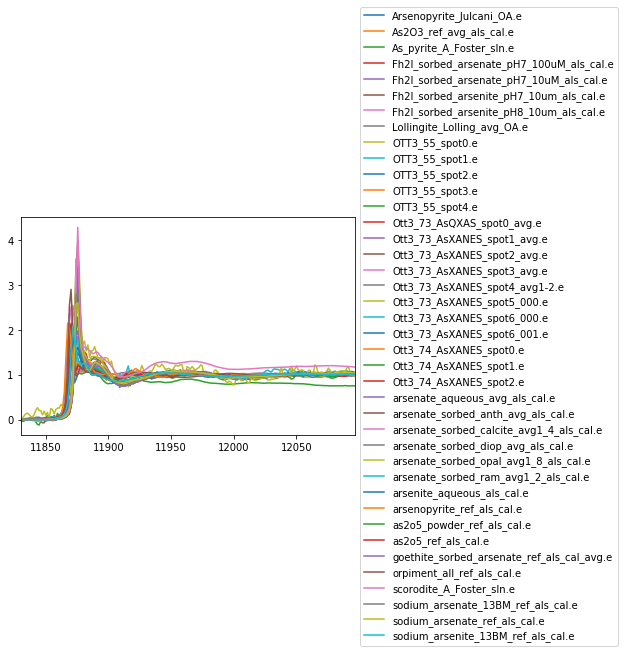

In [8]:
# construct a single DataFrame with all interpolated reference and unknown spectra
interpolated_sample_data_reference_and_unknown_df = InterpolatedSpectrumSet.get_interpolated_spectrum_set_df(
    energy_range=interpolate_energy_range,
    spectrum_set=set(itertools.chain(sample_data_reference_list, sample_data_unknown_list)))
interpolated_sample_data_reference_and_unknown_df.plot().legend(loc='center left', bbox_to_anchor=(1, 0.5))
interpolated_sample_data_reference_and_unknown_df.head()

In [9]:
# this is a helper function for cluster_with_sig_cut
def permute_row_elements(df):
    for i in range(df.shape[0]):
        df.values[i, :] = sklearn.utils.shuffle(df.values[i, :])
    return df
# demonstrate permuting row elements
x_df = pd.DataFrame(data=np.array(range(9)).reshape((3,3)))
print('before permuting row elements:')
print(x_df.head())
permute_row_elements(x_df)
print('after permuting row elements:')
print(x_df)

before permuting row elements:
   0  1  2
0  0  1  2
1  3  4  5
2  6  7  8
after permuting row elements:
   0  1  2
0  1  0  2
1  4  3  5
2  8  7  6


In [10]:
def cluster_with_sig_cut(variable_by_sample_df, title, pdist_metric, linkage_method):
    #pdist_metric = 'correlation'
    distance_for_sample_pairs = pdist(X=np.transpose(variable_by_sample_df.values), metric=pdist_metric)
    print('{}: {} sample pairs'.format(title, len(distance_for_sample_pairs)))
    plt.figure()
    plt.title(title)
    plt.hist(distance_for_sample_pairs)
    plt.xlabel('{} distance'.format(pdist_metric))
    plt.ylabel('{} pairs'.format(variable_by_sample_df.shape))
    plt.show()

    resample_count = 1000
    expected_distance_list = []
    for i in range(resample_count):
        # permute the elements of each row of variable_by_sample_df
        p_variable_by_sample_df = permute_row_elements(variable_by_sample_df.copy())
        p_distance_for_sample_pairs = pdist(X=np.transpose(p_variable_by_sample_df.values), metric=pdist_metric)
        p_linkage_distance_variable_by_sample = hc.linkage(y=p_distance_for_sample_pairs, method=linkage_method)
        p_dendrogram = hc.dendrogram(Z=p_linkage_distance_variable_by_sample, no_plot=True)
        expected_distance_list.extend([d for (_, _, d, _) in p_dendrogram['dcoord']])

    p = 95.0
    alpha = 1.0 - p/100.0
    cutoff_distance = np.percentile(expected_distance_list, q=p)
    print('cutoff distance is {}'.format(cutoff_distance))

    plt.figure()
    plt.hist(expected_distance_list)
    plt.title('dendrogram distance null distribution')
    plt.show()

    linkage_distance_variable_by_sample = hc.linkage(y=distance_for_sample_pairs, method=linkage_method)
    plt.figure(figsize=(3.7, 7))
    dendrogram = hc.dendrogram(
        Z=linkage_distance_variable_by_sample,
        orientation='left',
        labels=variable_by_sample_df.columns)
    
    icoords = [i for i in itertools.chain(dendrogram['icoord'])]
    
    plt.vlines(cutoff_distance, ymin=np.min(icoords), ymax=np.max(icoords))
    plt.title('{}\n{} linkage'.format(title, linkage_method))
    plt.xlabel('{} distance'.format(pdist_metric))
    plt.savefig(title + '.pdf', format='pdf')
    plt.show()
    


reference column list has 24 elements:
('Arsenopyrite_Julcani_OA.e',
 'As2O3_ref_avg_als_cal.e',
 'As_pyrite_A_Foster_sln.e',
 'Fh2l_sorbed_arsenate_pH7_100uM_als_cal.e',
 'Fh2l_sorbed_arsenate_pH7_10uM_als_cal.e',
 'Fh2l_sorbed_arsenite_pH7_10um_als_cal.e',
 'Fh2l_sorbed_arsenite_pH8_10um_als_cal.e',
 'Lollingite_Lolling_avg_OA.e',
 'arsenate_aqueous_avg_als_cal.e',
 'arsenate_sorbed_anth_avg_als_cal.e',
 'arsenate_sorbed_calcite_avg1_4_als_cal.e',
 'arsenate_sorbed_diop_avg_als_cal.e',
 'arsenate_sorbed_opal_avg1_8_als_cal.e',
 'arsenate_sorbed_ram_avg1_2_als_cal.e',
 'arsenite_aqueous_als_cal.e',
 'arsenopyrite_ref_als_cal.e',
 'as2o5_powder_ref_als_cal.e',
 'as2o5_ref_als_cal.e',
 'goethite_sorbed_arsenate_ref_als_cal_avg.e',
 'orpiment_all_ref_als_cal.e',
 'scorodite_A_Foster_sln.e',
 'sodium_arsenate_13BM_ref_als_cal.e',
 'sodium_arsenate_ref_als_cal.e',
 'sodium_arsenite_13BM_ref_als_cal.e')
core ott3 column list has 16 elements:
('OTT3_55_spot0.e',
 'OTT3_55_spot1.e',
 'OTT3_55

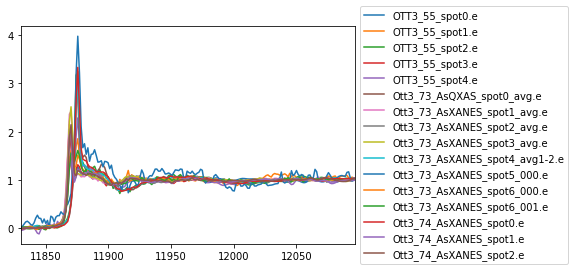

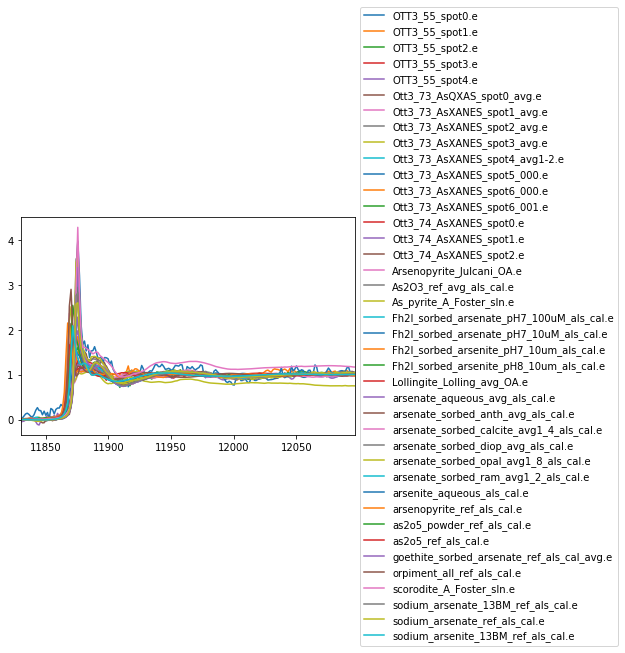

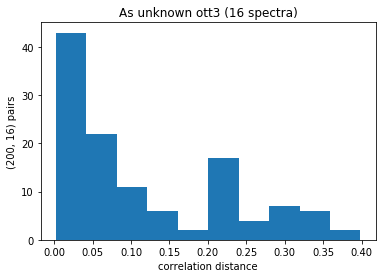

cutoff distance is 0.2496900008393527


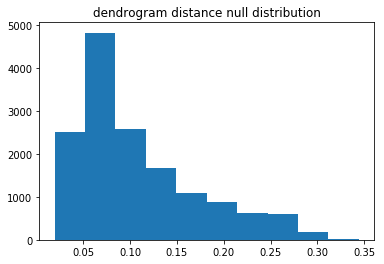

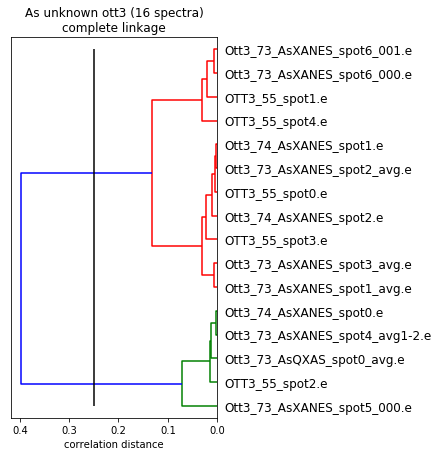

As unknown ott3 and references (40 spectra): 780 sample pairs


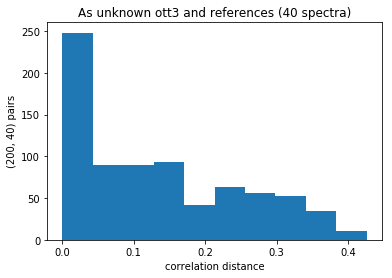

cutoff distance is 0.26451370254882905


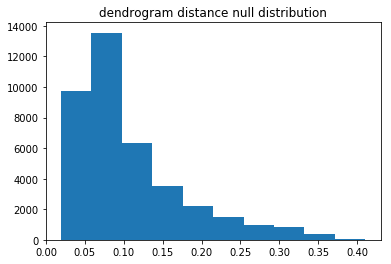

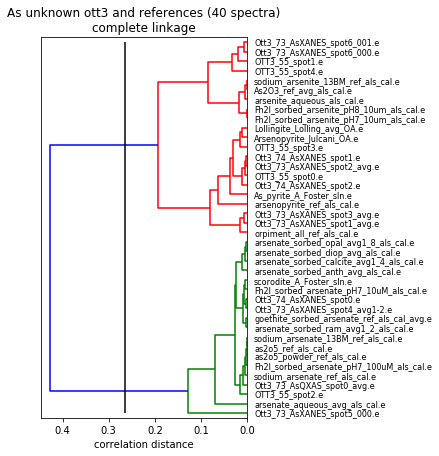

In [13]:
for core in ['ott3',]:

    ref_column_list = tuple([
        c for 
        c in interpolated_sample_data_reference_and_unknown_df.columns 
        if any(['als_cal' in c, 'sln' in c, 'OA' in c])])

    print('reference column list has {} elements:\n{}'.format(len(ref_column_list), pprint.pformat(ref_column_list)))

    unknown_column_list = tuple([
        c for 
        c in interpolated_sample_data_reference_and_unknown_df.columns
        if core in c.lower()])

    print('core {} column list has {} elements:\n{}'.format(core, len(unknown_column_list), pprint.pformat(unknown_column_list)))

    unknown_interpolated_df = interpolated_sample_data_reference_and_unknown_df.loc[:, unknown_column_list]
    unknown_interpolated_df.plot().legend(loc='center left', bbox_to_anchor=(1, 0.5))
    unknown_interpolated_df.head()

    unknown_and_reference_column_list = tuple(itertools.chain(unknown_column_list, ref_column_list))
    unknown_and_reference_interpolated_df = interpolated_sample_data_reference_and_unknown_df.loc[:, unknown_and_reference_column_list]
    unknown_and_reference_interpolated_df.plot().legend(loc='center left', bbox_to_anchor=(1, 0.5))
    unknown_and_reference_interpolated_df.head()

    cluster_with_sig_cut(
        unknown_interpolated_df,
        title='As unknown {} ({} spectra)'.format(core, unknown_interpolated_df.shape[1]),
        pdist_metric='correlation',
        linkage_method='complete')

    cluster_with_sig_cut(
        unknown_and_reference_interpolated_df,
        title='As unknown {} and references ({} spectra)'.format(core, unknown_and_reference_interpolated_df.shape[1]),
        pdist_metric='correlation',
        linkage_method='complete')
